In [265]:
import struct
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle

读取图片操作

In [266]:
def decode_labels(file):  # 读取标签数据

    with open(file, "rb") as f:
        binary_data = f.read()

    _, num_items = struct.unpack_from(">II", binary_data, 0)
    labels = struct.unpack_from("B" * num_items, binary_data, 8)
    return np.array(labels).reshape(-1, 1).astype(np.int)


def decode_images(file):  # 读取图片数据

    with open(file, "rb") as f:
        binary_data = f.read()

    _, num_images, rows, cols = struct.unpack_from(">IIII", binary_data, 0)
    images = struct.unpack_from("B" * (num_images * cols * rows), binary_data, 16)
    return np.array(images).reshape(-1, rows * cols)

In [267]:
def one_hot(t, num_classes):   # 将标量转换为矩阵，方便计算
    
    rows = t.shape[0]
    output = np.zeros((rows, num_classes))
    
    for row in range(rows):
        label = t[row, 0]
        output[row, label] = 1
    return output

def norm_image(image):  # 将图像进行标准化
    return (image / 255 - 0.5).astype(np.float32)

y = np.array([1,3,6,7,2,5,8])[...,None]
one_hot(y, 10)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

# 定义数据集和数据加载器

In [268]:
class Dataset:
    def __init__(self, image_file, label_file, num_classes=10):
        self.images = decode_images(image_file)
        self.labels = decode_labels(label_file)
        self.num_classes = num_classes
        self.labels_one_hot = one_hot(self.labels, num_classes)
        
    # 获取他的一个item，  dataset = Dataset(),   dataset[index]
    def __getitem__(self, index):
        return self.images[index], self.labels[index], self.labels_one_hot[index]
    
    # 获取数据集的长度，个数
    def __len__(self):
        return len(self.images)
    
class DataLoaderIterator:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.cursor = 0
        self.indexs = list(range(self.dataloader.count_data))  # 0, ... 60000
        if self.dataloader.shuffle:
            # 打乱一下
            np.random.shuffle(self.indexs)        
            
    def __next__(self):
        if self.cursor >= self.dataloader.count_data:
            raise StopIteration()
            
        batch_data = []
        remain = min(self.dataloader.batch_size, self.dataloader.count_data - self.cursor) 
        for n in range(remain):
            index = self.indexs[self.cursor]
            image_and_label = self.dataloader.dataset[index]
            
            # 如果batch没有初始化，则初始化n个list成员
            if len(batch_data) == 0:
                batch_data = [[] for i in range(len(image_and_label))]
            #直接append进去
            for index, item in enumerate(image_and_label):
                batch_data[index].append(item)
            self.cursor += 1
            
        # 通过np.vstack一次性实现合并，而非每次一直在合并
        for index in range(len(batch_data)):
            batch_data[index] = np.vstack(batch_data[index])
        return batch_data
    
class DataLoader:
    
    # shuffle 打乱
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.shuffle = shuffle
        self.count_data = len(dataset)
        self.batch_size = batch_size
        
    def __iter__(self):
        return DataLoaderIterator(self)
    
    def __len__(self):
        return math.ceil(len(self.dataset) / self.batch_size)

In [269]:
# 测试DataLoader
dataset = Dataset("../dataset/t10k-images-idx3-ubyte", "../dataset/t10k-labels-idx1-ubyte")
loader = DataLoader(dataset, 256)
print(len(loader))
for ibatch, (images, labels, targets) in enumerate(loader):
    print(ibatch, images.shape, labels.shape, targets.shape)

40
0 (256, 784) (256, 1) (256, 10)
1 (256, 784) (256, 1) (256, 10)
2 (256, 784) (256, 1) (256, 10)
3 (256, 784) (256, 1) (256, 10)
4 (256, 784) (256, 1) (256, 10)
5 (256, 784) (256, 1) (256, 10)
6 (256, 784) (256, 1) (256, 10)
7 (256, 784) (256, 1) (256, 10)
8 (256, 784) (256, 1) (256, 10)
9 (256, 784) (256, 1) (256, 10)
10 (256, 784) (256, 1) (256, 10)
11 (256, 784) (256, 1) (256, 10)
12 (256, 784) (256, 1) (256, 10)
13 (256, 784) (256, 1) (256, 10)
14 (256, 784) (256, 1) (256, 10)
15 (256, 784) (256, 1) (256, 10)
16 (256, 784) (256, 1) (256, 10)
17 (256, 784) (256, 1) (256, 10)
18 (256, 784) (256, 1) (256, 10)
19 (256, 784) (256, 1) (256, 10)
20 (256, 784) (256, 1) (256, 10)
21 (256, 784) (256, 1) (256, 10)
22 (256, 784) (256, 1) (256, 10)
23 (256, 784) (256, 1) (256, 10)
24 (256, 784) (256, 1) (256, 10)
25 (256, 784) (256, 1) (256, 10)
26 (256, 784) (256, 1) (256, 10)
27 (256, 784) (256, 1) (256, 10)
28 (256, 784) (256, 1) (256, 10)
29 (256, 784) (256, 1) (256, 10)
30 (256, 784) (25

# 定义模型结构

In [6]:
# 定义模块，所有的模块将会继承该基类
class Module:
    def __init__(self):
        self.train_mode = False
        
    def __call__(self, *args):
        return self.forward(*args)
    
    def train(self):
        self.train_mode = True
        for m in self.modules():
            m.train()
        
    def eval(self):
        self.train_mode = False
        for m in self.modules():
            m.eval()
        
    def modules(self):
        ms = []
        for attr in self.__dict__:
            m = self.__dict__[attr]
            if isinstance(m, Module):
                ms.append(m)
        return ms
    
    def params(self):
        ps = []
        for attr in self.__dict__:
            p = self.__dict__[attr]
            if isinstance(p, Parameter):
                ps.append(p)
            
        ms = self.modules()
        for m in ms:
            ps.extend(m.params())
        return ps
    
    def info(self, n):
        ms = self.modules()
        name = self.__class__.__name__
        output = f"{name}\n"
        for m in ms:
            output += ('  '*(n+1)) + f"{m.info(n+1)}\n"
        return output[:-1]
    
    def __repr__(self):
        return self.info(0)
    
# 定义参数类，所有需要迭代更新的参数都会继承该类
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros(data.shape)
        
    def zero_grad(self):
        self.grad[...] = 0

class Linear(Module):  # 定义连接层
    def __init__(self, num_input, num_output):
        super().__init__()
        self.weight = Parameter(np.random.normal(0, 1, size=(num_input, num_output)))  # 初始化权重
        self.bias   = Parameter(np.zeros((num_output,)))
    
    def forward(self, x):  # 正向传播
        # save for backward
        self.x = x
        return x @ self.weight.data + self.bias.data
    
    def backward(self, g):  # 反向传播
        self.weight.grad += self.x.T @ g
        self.bias.grad   += np.sum(g, axis=0)
        return g @ self.weight.data.T
    
class Sigmoid(Module):  # 定义激活函数对象
    def __init__(self):
        super().__init__()
    
    def sigmoid_impl(self, x):  #定义激活函数 
        return 1 / (1 + np.exp(-x))
    
    def forward(self, x):  # 正向传播
        # save for backward
        self.x = x
        return self.sigmoid_impl(x)
    
    def backward(self, g):  # 反向传播
        return g * self.sigmoid_impl(self.x) * (1 - self.sigmoid_impl(self.x))
    
class Sequencial(Module):
    def __init__(self, *args):
        super().__init__()
        self.items = list(args)
        
    def modules(self):
        return self.items
    
    def forward(self, x):
        for m in self.items:
            x = m(x)
        return x
    
    def backward(self, G):
        for item in self.items[::-1]:
            G = item.backward(G)
        return G
    
# 包含了softmax操作和loss计算，返回的是loss
class SoftmaxCrossEntropyLoss(Module):  # 定义损失函数
    def __init__(self):
        super().__init__()
    
    def softmax(self, predict):  # 定义softmax的计算方法
        exp_predict = np.exp(predict)
        total = np.sum(exp_predict, axis=1, keepdims=True)
        return exp_predict / total
    
    def forward(self, x, target):  # 前向传播
        self.batch_size  = len(x)
        self.probability = self.softmax(x)
        self.target      = target
        return -np.sum(target * np.log(self.probability)) / self.batch_size
    
    def backward(self, g=1):  # 反向传播
        g = g * self.probability
        return (g - self.target) / self.batch_size
    
    
class Network(Module):  # 定义网路层
    def __init__(self, num_feature, num_hidden, num_classes):
        super().__init__()
        
        self.layers = Sequencial(
            Linear(num_feature, num_hidden),
            Sigmoid(),
            Linear(num_hidden, num_classes)
        )
        self.loss = SoftmaxCrossEntropyLoss()
        
    def inference(self, x):  # 获得特征向量
        return self.layers(x)
        
    def forward(self, x, target):  # 前向传播
        return self.loss.forward(self.inference(x), target)
    
    def backward(self):  # 反向传播
        g = self.loss.backward()
        self.layers.backward(g)

class Optimizer:
    def __init__(self, params, lr):
        self.lr = lr
        self.params = params

    def zero_grad(self):
        for param in self.params:
            param.zero_grad()
            
    def set_lr(self, lr):
        self.lr = lr
        
        
class SGD(Optimizer):
    def __init__(self, params, lr=1e-3):
        super().__init__(params, lr)
    
    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad
            
            
class SGDMomentum(Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9):
        super().__init__(params, lr)
        self.momentum = momentum
        
        for param in self.params:
            param.v = 0
    
    # 移动平均
    def step(self):
        for param in self.params:
            param.v = self.momentum * param.v - self.lr * param.grad
            param.data += param.v
            
            
class AdamW(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, l2_regularization = 0):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.l2_regularization = l2_regularization
        self.t = 0
        
        for param in self.params:
            param.m = 0
            param.v = 0
            
    # 指数移动平均
    def step(self):
        eps = 1e-8
        self.t += 1
        for param in self.params:
            g = param.grad + self.l2_regularization * param.data
            param.m = self.beta1 * param.m + (1 - self.beta1) * g
            param.v = self.beta2 * param.v + (1 - self.beta2) * g ** 2
            mt_ = param.m / (1 - self.beta1 ** self.t)
            vt_ = param.v / (1 - self.beta2 ** self.t)
            param.data -= self.lr * mt_ / (np.sqrt(vt_) + eps)
            
            
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, l2_regularization = 0):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.l2_regularization = l2_regularization
        self.t = 0
        
        for param in self.params:
            param.m = 0
            param.v = 0
            
    # 指数移动平均
    def step(self):
        eps = 1e-8
        self.t += 1
        for param in self.params:
            g = param.grad
            param.m = self.beta1 * param.m + (1 - self.beta1) * g
            param.v = self.beta2 * param.v + (1 - self.beta2) * g ** 2
            mt_ = param.m / (1 - self.beta1 ** self.t)
            vt_ = param.v / (1 - self.beta2 ** self.t)
            param.data -= self.lr * mt_ / (np.sqrt(vt_) + eps) + self.l2_regularization * param.data

def save_model(file, model):
    
    # 改成只保存parameter
    with open(file, "wb") as f:
        f.write(pickle.dumps(model))
        
def load_model(file):
    
    # 改成只保存parameter
    with open(file, "rb") as f:
        return pickle.loads(f.read())

# 对于Adam的权重衰减（L2正则化）而言，如果按照简单的SGD做法，是不合理的。改进后得到AdamW
<img src="adamw.png"/>

# 关于正则化：
- 对于模型f(x)关于训练数据集的平均损失，为经验风险或者经验损失EMP
    - 经验风险最小化(empirical risk minimization, ERM)，即最小化f(x)关于训练集的平均损失
    - MLE（极大似然估计）就是经验风险最小化的例子
    - $R_{emp}(f) = \frac{1}{N}\sum_{i=1}^{N}L(y_i, f(x_i))$
- 当样本量小时，经验风险最小化效果未必就好，容易产生过拟合，而结构风险最小化(structural risk minimization, SRM)是防止过拟合提出的策略
    - 结构风险最小化等价于正则化
    - 结构风险在经验风险的基础上加上表示模型复杂度的正则化项，结构风险定义如下：
        - $R_{srm}(f) = \frac{1}{N}\sum_{i=1}^{N}L(y_i, f(x_i)) + \lambda J(f)$
        - $\lambda$表示为正则化权重系数，通常取一个很小值，例如1e-5
        - $J(f)$函数通常是对模型所有参数取L2范数、L1范数，被称之为L2正则化、L1正则化

训练模型

In [7]:
batch_size  = 256  # 每一个batch的大小
num_hidden  = 256  # 获取的特征值大小
num_classes = 10  # 分类的数量
num_feature = 784

train_dataset = Dataset("dataset/train-images-idx3-ubyte", "dataset/train-labels-idx1-ubyte", num_classes)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = Dataset("dataset/t10k-images-idx3-ubyte", "dataset/t10k-labels-idx1-ubyte", num_classes)
test_loader = DataLoader(test_dataset, 1024, shuffle=True)

In [10]:
batch_per_epoch = len(train_loader)  # 计算需要多少批次可以训练完成一轮
train_epochs    = 10 # 定义训练的次数

lr_schedule = {  # 定义学习率训练策略
    0: 1e-3,
    9: 1e-3
}

# 定义网络结构
network = Network(num_feature, num_hidden, num_classes)
print(network)

# 定义优化器
# lr_schedule = {  # 定义学习率训练策略
#     0: 1e-1,
#     9: 1e-1
# }
#optim   = SGDMomentum(network.params(), 0.1)  # 0.929


# lr_schedule = {  # 定义学习率训练策略
#     0: 1e-3,
#     9: 1e-3
# }
#optim   = Adam(network.params(), 1e-3)  # 0.930

lr_schedule = {  # 定义学习率训练策略
    0: 1e-3,
    9: 1e-3
}
optim   = AdamW(network.params(), 1e-3, l2_regularization=1e-4)  # 0.934

for epoch_index in range(train_epochs):  # 开始进行训练
    
    if epoch_index in lr_schedule:  # 使用学习率策略
        optim.set_lr(lr_schedule[epoch_index])
    
    for batch_index, (train_batch_images, train_batch_labels, train_batch_onehots) in enumerate(train_loader):
        niter       = epoch_index * batch_per_epoch + batch_index  # 获取当前训练的次数
        
        train_batch_images = norm_image(train_batch_images)
        loss = network(train_batch_images, train_batch_onehots)
        
        optim.zero_grad()
        network.backward()
        optim.step()
    
        if niter % 100 == 0: # 每训练100张图片计算一次精度
            epoch_index_float = epoch_index + batch_index / batch_per_epoch
            
            correct = 0
            for test_batch_images, test_batch_labels, test_batch_onehots in test_loader:
                predict        = network.inference(norm_image(test_batch_images))
                predict_labels = predict.argmax(axis=1)
                correct        += (predict_labels == test_batch_labels[:, 0]).sum()
                
            accuracy       = correct.sum() / len(test_loader.dataset)
            print(f"Iter: {niter}, Epoch: {epoch_index_float:.2f}/{train_epochs}, LR: {optim.lr:.6f}, Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}")

Network
  Sequencial
    Linear
    Sigmoid
    Linear
  SoftmaxCrossEntropyLoss
Iter: 0, Epoch: 0.00/10, LR: 0.001000, Loss: 15.831, Test Accuracy: 0.114
Iter: 100, Epoch: 0.43/10, LR: 0.001000, Loss: 1.700, Test Accuracy: 0.642
Iter: 200, Epoch: 0.85/10, LR: 0.001000, Loss: 1.196, Test Accuracy: 0.753
Iter: 300, Epoch: 1.28/10, LR: 0.001000, Loss: 0.956, Test Accuracy: 0.798
Iter: 400, Epoch: 1.70/10, LR: 0.001000, Loss: 0.874, Test Accuracy: 0.824
Iter: 500, Epoch: 2.13/10, LR: 0.001000, Loss: 0.418, Test Accuracy: 0.840
Iter: 600, Epoch: 2.55/10, LR: 0.001000, Loss: 0.545, Test Accuracy: 0.853
Iter: 700, Epoch: 2.98/10, LR: 0.001000, Loss: 0.374, Test Accuracy: 0.863
Iter: 800, Epoch: 3.40/10, LR: 0.001000, Loss: 0.478, Test Accuracy: 0.873
Iter: 900, Epoch: 3.83/10, LR: 0.001000, Loss: 0.277, Test Accuracy: 0.877
Iter: 1000, Epoch: 4.26/10, LR: 0.001000, Loss: 0.434, Test Accuracy: 0.888
Iter: 1100, Epoch: 4.68/10, LR: 0.001000, Loss: 0.386, Test Accuracy: 0.892
Iter: 1200, Epoch:

预测

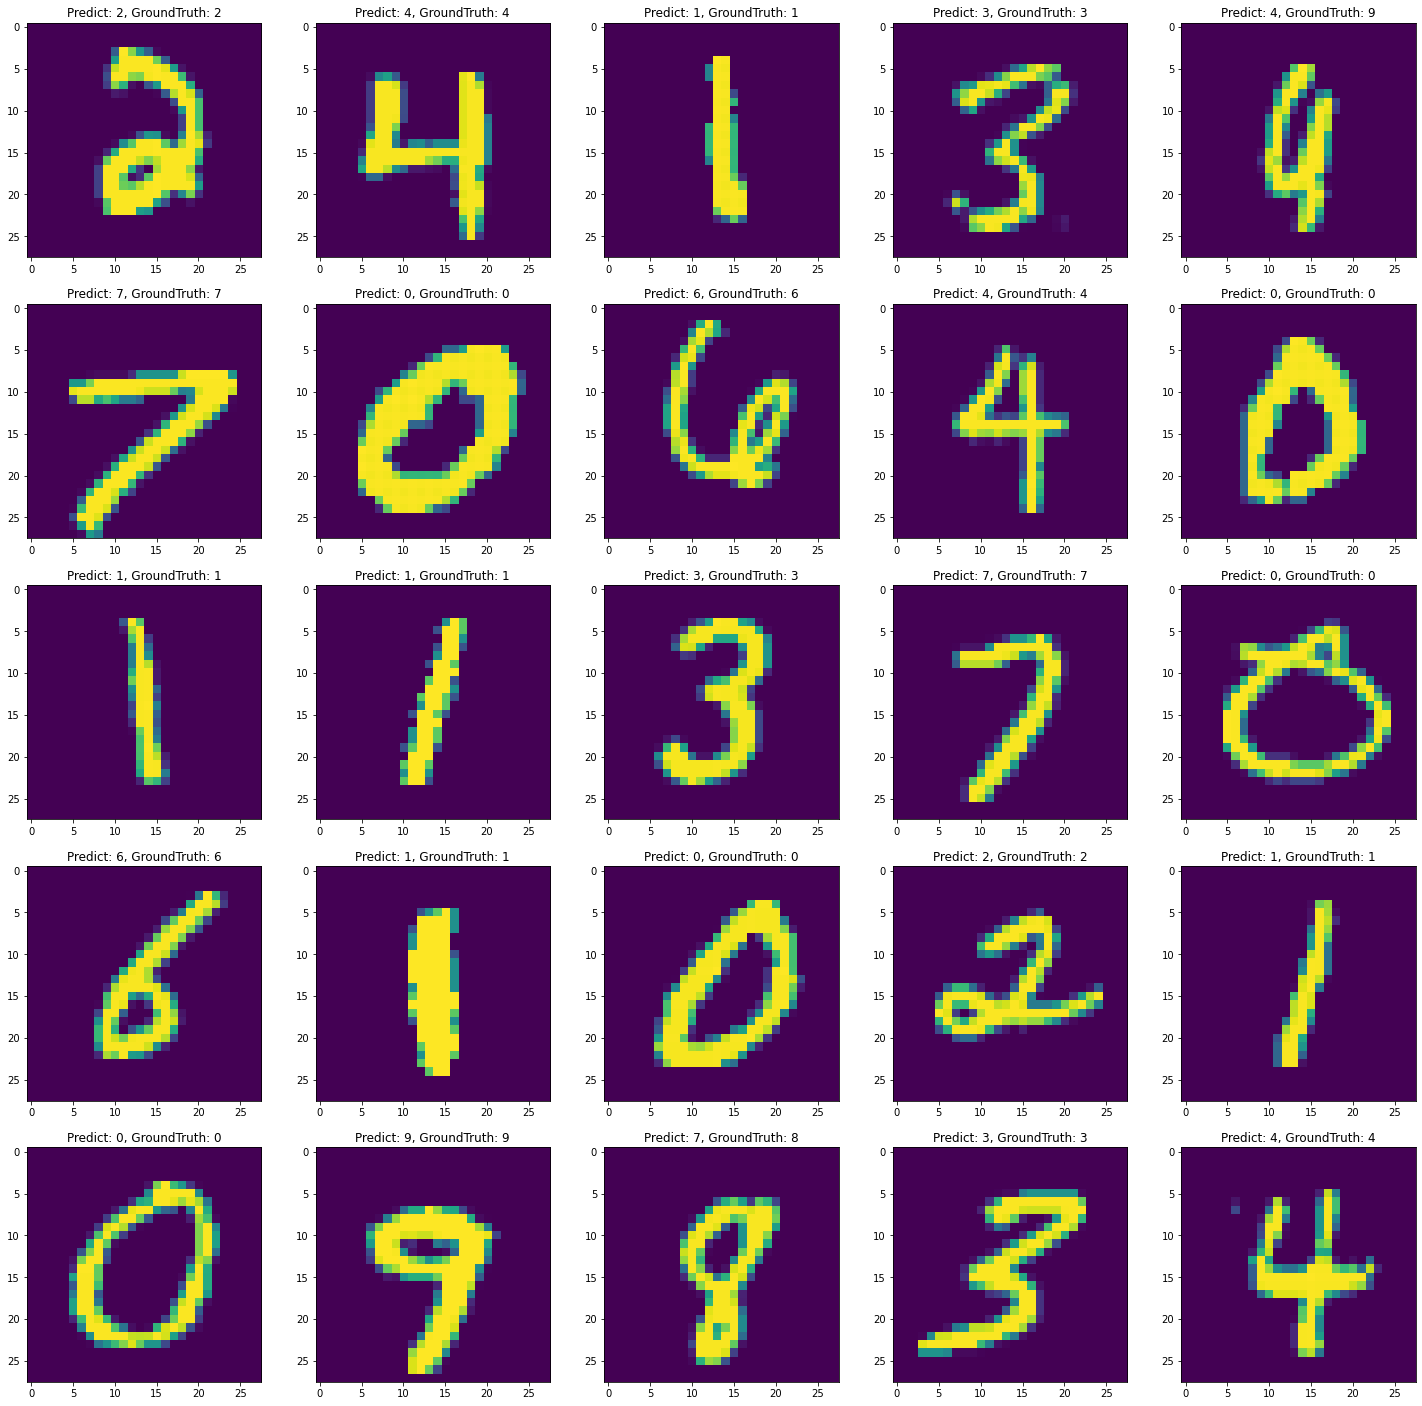

In [12]:
# network = load_model("last.pt")
show_rows = 5 # 五行
show_cols = 5 # 五列
select_count = show_rows * show_cols
select_iter = iter(test_loader)
test_batch_images, test_batch_labels, test_batch_onehots = next(select_iter)

predict        = network.inference(norm_image(test_batch_images))  # 进行网络预测
predict_labels = predict.argmax(axis=1)  # 获取预测的标签值

plt.figure(figsize=(show_rows * 5, show_cols * 5))  # 定义画板的大小
for i in range(select_count):  # 显示图片和标题

    plt.subplot(show_rows, show_cols, i+1)

    predict_label      = predict_labels[i]
    ground_truth_label = test_batch_labels[i, 0]
    image              = test_batch_images[i].reshape(28, 28)

    plt.title(f"Predict: {predict_label}, GroundTruth: {ground_truth_label}")
    plt.imshow(image)